# 4 Training and Modeling Data<a id='4_Training_and_Modeling_Data'></a>

## Contents <a id ="Content" > </a>

* [Introduction](#Introduction)
* [Imports](#Imports)
* [Train Test Split](#Train_Test_Split) 
* [Training and Modeling](#Training_and_Modeling)
    * [Model Selection](#Model_Selection)
    * [Evaluation Metrics](#Evaluation-Metrics)
        * [Training and Modeling](#Train_and_Model)
        * [Hyperparameter Tuning and Model Training](#Hyperparameter_Tuning_Training)
            * [Logistic Regression](#Logistic_Regression)
            * [Evaluation](#Evaluation)
* [Additional Models](#AdditionalModels)
* [Summary](#Summary)
* [Recommendations](#Recom)

## Introduction <a id = 'Introduction'></a>

## Imports <a id="Imports"></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import pipeline
from sklearn import model_selection
from sklearn import linear_model 

#from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
import matplotlib.pyplot as plt

# remove warning
#import warnings
#warnings.filterwarnings("ignore")


In [2]:
X_train = pd.read_csv("../data/4.X_train.csv")
y_train = pd.read_csv("../data/4.y_train.csv")
X_test = pd.read_csv("../data/4.X_test.csv")
y_test = pd.read_csv("../data/4.y_test.csv")

In [3]:
pd.__version__

'1.2.4'

In [4]:
X_train.shape,y_train.shape

((7088, 16), (7088, 1))

In [5]:
X_test.shape,y_test.shape

((3039, 16), (3039, 1))

In [6]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,7088.0,-3.454018e-16,1.000071,-2.531322,-0.661337,-0.038008,0.709986,3.327966
Credit_Limit,7088.0,8.597793e+00,0.930669,7.271217,7.841395,8.418587,9.298671,10.449178
Total_Revolving_Bal,7088.0,9.103482e-01,0.638103,0.000000,0.248822,1.000000,1.396112,1.977219
Total_Trans_Amt,7088.0,8.167921e+00,0.656979,6.390241,7.674617,8.267449,8.468633,9.824661
Avg_Utilization_Ratio,7088.0,2.753070e-01,0.276635,0.000000,0.023000,0.175000,0.502000,0.999000
Gender_Encoded,7088.0,5.328725e-01,0.498953,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,7088.0,2.344949e+00,1.299597,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,7088.0,2.839306e+00,1.215114,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,7088.0,2.175226e+00,1.334986,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,7088.0,1.081546e+00,0.330233,1.000000,1.000000,1.000000,1.000000,4.000000


In [7]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,3039.0,1.760867e-16,1.000165,-2.545475,-0.671517,-0.046864,0.702719,2.701607
Credit_Limit,3039.0,8.616519e+00,0.940983,7.271217,7.854381,8.432724,9.328701,10.449178
Total_Revolving_Bal,3039.0,9.134881e-01,0.640117,0.000000,0.349961,1.000000,1.401403,1.961808
Total_Trans_Amt,3039.0,8.157574e+00,0.648578,6.234411,7.682021,8.271293,8.453401,9.797849
Avg_Utilization_Ratio,3039.0,2.739293e-01,0.273522,0.000000,0.022500,0.177000,0.503500,0.994000
Gender_Encoded,3039.0,5.202369e-01,0.499673,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,3039.0,2.349128e+00,1.297511,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,3039.0,2.851925e+00,1.201185,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,3039.0,2.199079e+00,1.332057,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,3039.0,1.088516e+00,0.341929,1.000000,1.000000,1.000000,1.000000,4.000000


## Training and Modeling <a id=Training_and_Modeling ></a>

### Model Selection <a id=Model_Selection ></a>

### Training and Modeling <a id=Train_and_Model>

### Fit Model on Intercept (naive model)

In [8]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().ravel()

In [9]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().ravel()

In [10]:
def threshhold_and_plot(y_test,target,n_points=50,plot=True):
    probs = np.linspace(0,1,n_points)
    def make_thresh(): 
        precision = [metrics.precision_score(y_test,np.where(target > thresh,1,0),zero_division=1) for thresh in probs]
        recall = [metrics.recall_score(y_test,np.where(target > thresh,1,0),labels=np.unique(target)) for thresh in probs]
        f1 = [metrics.f1_score(y_test,np.where(target > thresh,1,0),labels=np.unique(target),zero_division=1) for thresh in probs]
        return precision,recall,f1

    precision,recall,f1 = make_thresh()
    if plot:
        plt.plot(probs,precision,label='precision')
        plt.plot(probs,recall,label='recall')
        plt.plot(probs,f1,label='f1')
        plt.title("Metrics at different threshold")
        plt.xlabel("Probability")
        plt.legend()
        return precision,recall,f1
    else:
        return precision,recall,f1
    
def max_thresh(score_vec):
    max_idx=np.argmax(score_vec)
    max_score=score_vec[max_idx]
    return max_idx,max_score

In [11]:
#plot roc

def plot_roc(actuals,preds):
    FPRs, TPRs, thresholds  = metrics.roc_curve(actuals, preds)
    print("FPRs:{}\n TPRs:{}\n thresholds:{}".format(FPRs,TPRs,thresholds))
    print("Area under ROC:{}".format(metrics.roc_auc_score(actuals, preds)))
    optimal_idx = np.argmax(TPRs - FPRs)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)

    # Plot the ROC curve
    plt.plot(FPRs, TPRs, color='red',lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC curve")
    plt.legend(loc="lower right")
    plt.show()

In [12]:
import itertools
# plot confusion matrix
def plot_confusion_matrx(confm):
    classes = [0, 1]
    plt.imshow(confm, interpolation='nearest', cmap=plt.cm.Greens)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = confm_train.max() / 2.
    for i, j in itertools.product(range(confm.shape[0]), range(confm.shape[1])):
        plt.text(j, i, format(confm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if confm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
# empty list to add result
model=[]
train_recall = []
test_recall = []
train_precision = []
test_precision = []
train_accuracy = []
test_accuracy = []
train_f1 = []
test_f1 = []

In [15]:
null_reg = linear_model.LogisticRegression(fit_intercept= False,max_iter=500,random_state=632966)

In [16]:
X_train_null = np.ones(shape=y_train.shape[0]).reshape(-1,1)
X_test_null = np.ones(shape=y_test.shape[0]).reshape(-1,1)

In [17]:
#fit on train and test data no tuning
null_train = null_reg.fit(X=X_train_null,y=y_train)
null_test = null_reg.fit(X=X_test_null,y=y_test)

In [18]:
#predict_proba and pred_prob returns two columns, second one is target
train_pred = null_train.predict_proba(X_train_null)
test_pred = null_train.predict_proba(X_test_null)

In [19]:
#base metrics: minmum performance
metrics.precision_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0),zero_division=1)

1.0

In [20]:
metrics.recall_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0))

0.0

In [21]:
metrics.f1_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0),zero_division=1)

0.0

In [22]:
#check to see if close to population value
print("Observed: {:.3f}, Fit: {:.3f}".format(y_train.mean(),train_pred[:,1].mean()))

Observed: 0.161, Fit: 0.161


In [23]:
model_params = {"model__C": (np.logspace(start=-4,stop=4,num=30))}

In [24]:
#pipe line has just model object
model_pipeline = pipeline.Pipeline(steps=[("model",null_reg)])

In [25]:
# set up cross-validator:
# 80/20 train/calibration split in this data (test data still held out)
# 200 iterations
# feel free to use another CV method and explain why
cross_validator = (
  model_selection.StratifiedShuffleSplit(train_size=0.8,
                                          random_state=1337,
                                          n_splits=50))

In [26]:
# set up grid search
model_grid = (
  model_selection.GridSearchCV(estimator=model_pipeline,
                           param_grid=model_params,
                           refit=True, # refit using best estimates
                           scoring="recall", # metric to optimize (can pick another)
                           cv=cross_validator,
                           n_jobs = -1))

In [27]:
%%time
# fit model on intercept (random guesses - baseline performance)
null_mod = model_grid.fit(X_train_null,y_train)

Wall time: 4.76 s


In [28]:
%%time
cv_scores = (
  model_selection.cross_val_score(null_mod,
                                  X_train_null,
                                  y_train,
                                  scoring="recall",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 3min 9s


In [29]:
cv_quantiles = np.quantile(a=cv_scores,q=[0.025,0.975])

In [30]:
print("Observed: {:.3f}".format(y_train.mean()))

Observed: 0.161


In [31]:
print(f" 2.5%:{cv_quantiles[0]:.3f},97.5%:{cv_quantiles[1]:.3f}")

 2.5%:0.000,97.5%:0.000


<AxesSubplot:ylabel='Count'>

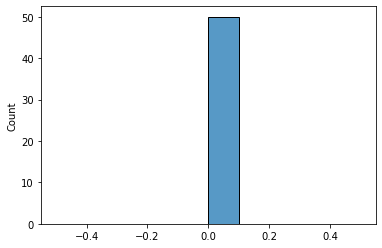

In [32]:
import seaborn as sns
sns.histplot(cv_scores, bins=10)

In [33]:
max_thresh(cv_scores)

(0, 0.0)

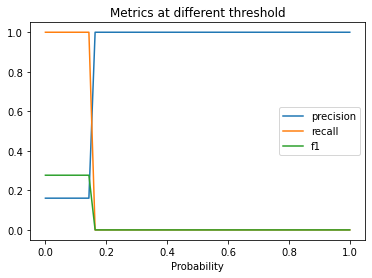

In [34]:
p, r, f = threshhold_and_plot(y_test,test_pred[:,1])

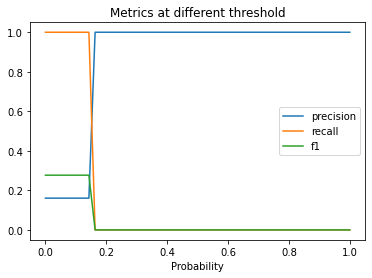

In [35]:
# now on train data
precision_lg, recall_lg, _ =  threshhold_and_plot(y_test=y_train, target=train_pred[:,1],n_points=50, plot=True)

In [36]:
auc_score = metrics.roc_auc_score(y_test, test_pred[:,1])
print(f"Scikit's ROC-AUC score of SVC model is {auc_score: .4f}")

Scikit's ROC-AUC score of SVC model is  0.5000


In [37]:
max_thresh(r)

(0, 1.0)

In [38]:
max_thresh(p)

(8, 1.0)

In [39]:
max_thresh(f)

(0, 0.27672242699177774)

In [40]:
# check to see if close to population value
print(f"Observed: {y_train.mean():.3f} Fit: {train_pred[:,1].mean():.3f}")

Observed: 0.161 Fit: 0.161


## Logistics Regression

Thinking of customer will not exit but he does, this means income loss for the Bank. Bank need to take the action steps for this scenario. This is false negative, and is "Recall". Banks  is looking for Recall to be maximized, greater the Recall lesser the chances of false negatives means lesser chances of predicting customers will not  exit where in reality they do.

In [41]:
clf_lg = linear_model.LogisticRegression(fit_intercept= True,max_iter=500,random_state=632966)

model_params_lg = {"model__C": (np.logspace(start=-4,stop=4,num=30))} 

model_pipeline_lg = pipeline.Pipeline(steps=[("model",clf_lg)])

cross_validator = (model_selection.StratifiedShuffleSplit(train_size=0.8,random_state=1337,n_splits=50))

# set up grid search
model_grid_lg = (
  model_selection.GridSearchCV(estimator=model_pipeline_lg,param_grid=model_params_lg,refit=True, # refit using best estimates
                           scoring="recall", cv=cross_validator,n_jobs = -1))

In [42]:
%%time
lg_mod = model_grid_lg.fit(X_train,y_train)

Wall time: 43.5 s


In [43]:
# Setting to the best combination of parameters
lr_reg = lg_mod.best_estimator_
# Fit the best algorithm to the data. 
lr_reg.fit(X_train, y_train)

Pipeline(steps=[('model',
                 LogisticRegression(C=10000.0, max_iter=500,
                                    random_state=632966))])

In [44]:
%%time
cv_scores_lg = (
  model_selection.cross_val_score(lr_reg,
                                  X_train,
                                  y_train,
                                  scoring="recall",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 2.19 s


In [45]:
cv_quantiles = np.quantile(a=cv_scores_lg,q=[0.025,0.975])
print(f" 2.5%:{cv_quantiles[0]:.3f},97.5%:{cv_quantiles[1]:.3f}")

 2.5%:0.318,97.5%:0.424


<AxesSubplot:ylabel='Count'>

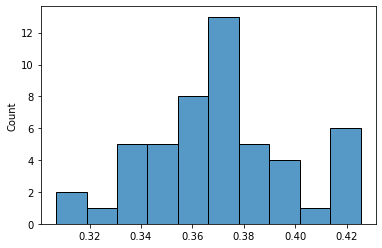

In [46]:
sns.histplot(cv_scores_lg, bins=10)

In [47]:
max_thresh(cv_scores_lg)

(3, 0.42543859649122806)

In [48]:
true_train_preds = lr_reg.predict(X_train)
true_test_preds = lr_reg.predict(X_test)

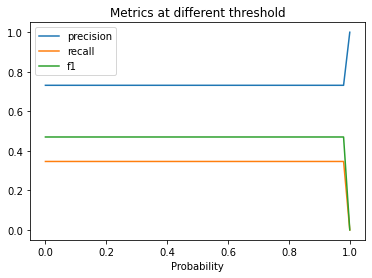

In [49]:
test_precision_lg, test_recall_lg, test_f1_lg =  threshhold_and_plot(y_test=y_test, target=true_test_preds,n_points=50, plot=True)

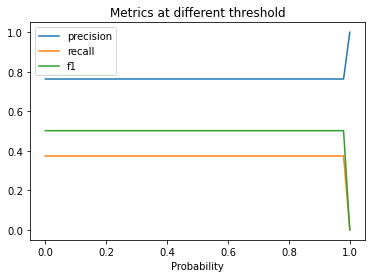

In [50]:
train_precision_lg, train_recall_lg, train_f1_lg =  threshhold_and_plot(y_test=y_train, target=true_train_preds,n_points=50, plot=True)

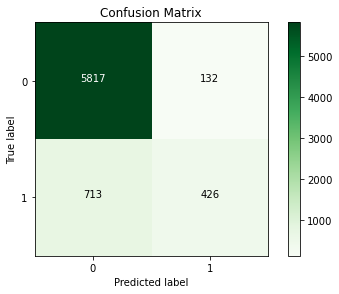

In [51]:
confm_train = metrics.confusion_matrix(y_train, true_train_preds)
plot_confusion_matrx(confm_train)

In [52]:
# from the confusion matrix
TP = true_pos = 419
TN = true_neg = 5822
FP = false_pos = 127
FN = false_neg = 720

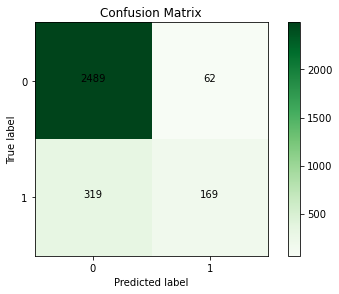

In [53]:
confm_test = metrics.confusion_matrix(y_test, true_test_preds)
plot_confusion_matrx(confm_test)

In [54]:
# from the confusion matrix
TP = true_pos = 169
TN = true_neg = 2492
FP = false_pos = 59
FN = false_neg = 321

In [55]:
max_recall_lg_idx, max_recall_lg_val = max_thresh(recall_lg)

In [56]:
print("Max recall - {} at index {}".format(max_recall_lg_val,max_recall_lg_idx))

Max recall - 1.0 at index 0


FPRs:[0.        0.0221886 1.       ]
 TPRs:[0.         0.37401229 1.        ]
 thresholds:[2 1 0]
Area under ROC:0.6759118441785908
Threshold value is: 1


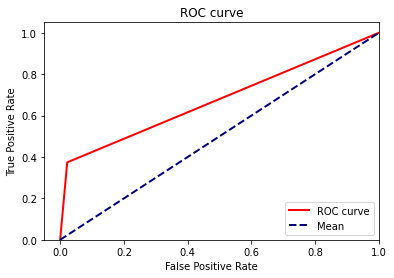

In [57]:
#plot roc
plot_roc(y_train, true_train_preds)

In [58]:
auc_score = metrics.roc_auc_score(y_train, true_train_preds)
print(f"ROC-AUC score of logistic model is {auc_score: .4f}")

ROC-AUC score of logistic model is  0.6759


In [59]:
print("Test Recall - {} and Train Recall {}".format(max(test_recall_lg),max(train_recall_lg)))

Test Recall - 0.3463114754098361 and Train Recall 0.3740122914837577


The recall on test data is only 0.34 ,and model is overfitting there is some discrepancy between test score and train score. let try regularization.

In [60]:
#classifier
clf_lg = linear_model.LogisticRegression(fit_intercept= True,max_iter=500,random_state=632966)

# Grid of parameters
model_params_lg = {"model__C": (np.logspace(start=-4,stop=4,num=30)),
              'model__solver' : ['liblinear','newton-cg','lbfgs','sag','saga'],
              'model__penalty': ['l2']} 

# pipeline
model_pipeline_lg = pipeline.Pipeline(steps=[("model",clf_lg)])

cross_validator = (model_selection.StratifiedShuffleSplit(train_size=0.8,random_state=1337,n_splits=50))

# set up grid search
model_grid_lg = (
  model_selection.GridSearchCV(estimator=model_pipeline_lg,param_grid=model_params_lg,refit=True, # refit using best estimates
                           scoring="recall", cv=cross_validator,n_jobs = -1))

In [61]:
%%time
# Fit the best algorithm to the data. 
model_grid_lg.fit(X_train, y_train)

Wall time: 9min 24s


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=50, random_state=1337, test_size=None,
            train_size=0.8),
             estimator=Pipeline(steps=[('model',
                                        LogisticRegression(max_iter=500,
                                                           random_state=632966))]),
             n_jobs=-1,
             param_grid={'model__C': array([1.00000000e-04, 1.88739182e-04, 3.56224789e-04, 6.72335754e-04,
       1.26896100e-03, 2.39502662e-03, 4.52035366e-03, 8.53167852e-03...
       2.04335972e-01, 3.85662042e-01, 7.27895384e-01, 1.37382380e+00,
       2.59294380e+00, 4.89390092e+00, 9.23670857e+00, 1.74332882e+01,
       3.29034456e+01, 6.21016942e+01, 1.17210230e+02, 2.21221629e+02,
       4.17531894e+02, 7.88046282e+02, 1.48735211e+03, 2.80721620e+03,
       5.29831691e+03, 1.00000000e+04]),
                         'model__penalty': ['l2'],
                         'model__solver': ['liblinear', 'newton-cg', 'lbfgs',
                   

In [62]:
model_grid_lg.best_params_,model_grid_lg.best_score_

({'model__C': 10000.0, 'model__penalty': 'l2', 'model__solver': 'lbfgs'},
 0.37131578947368415)

In [63]:
# Setting to the best combination of parameters
lr_reg = model_grid_lg.best_estimator_
# Fit the best algorithm to the data. 
lr_reg.fit(X_train, y_train)

Pipeline(steps=[('model',
                 LogisticRegression(C=10000.0, max_iter=500,
                                    random_state=632966))])

In [64]:
true_train_preds = lr_reg.predict(X_train)
true_test_preds = lr_reg.predict(X_test)

In [65]:
%%time
cv_scores_lg = (
  model_selection.cross_val_score(lr_reg,
                                  X_train,
                                  y_train,
                                  scoring="recall",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 1.82 s


In [66]:
cv_quantiles = np.quantile(a=cv_scores_lg,q=[0.025,0.975])
print(f" 2.5%:{cv_quantiles[0]:.3f},97.5%:{cv_quantiles[1]:.3f}")

 2.5%:0.318,97.5%:0.424


<AxesSubplot:ylabel='Count'>

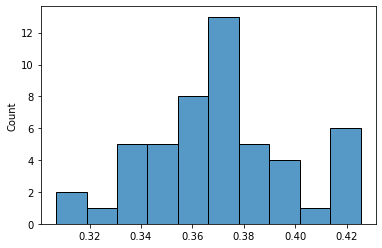

In [67]:
sns.histplot(cv_scores_lg, bins=10)

In [68]:
max_thresh(cv_scores_lg)

(3, 0.42543859649122806)

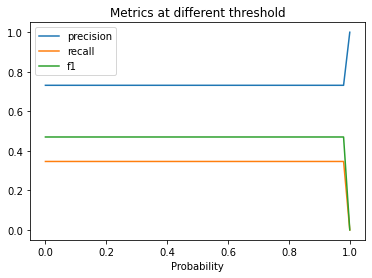

In [69]:
test_precision_lg, test_recall_lg, test_precision_f1 =  threshhold_and_plot(y_test=y_test, target=true_test_preds,n_points=50, plot=True)

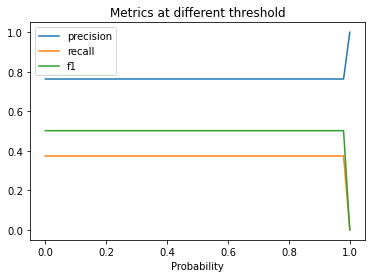

In [70]:
train_precision_lg, train_recall_lg, train_precision_f1 =  threshhold_and_plot(y_test=y_train, target=true_train_preds,n_points=50, plot=True)

FPRs:[0.        0.0221886 1.       ]
 TPRs:[0.         0.37401229 1.        ]
 thresholds:[2 1 0]
Area under ROC:0.6759118441785908
Threshold value is: 1


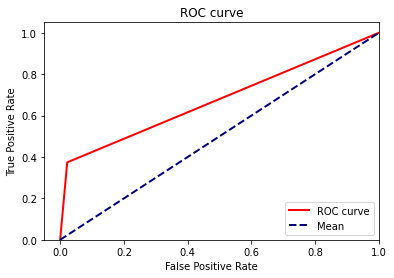

In [71]:
#plot roc
plot_roc(y_train, true_train_preds)

In [72]:
auc_score = metrics.roc_auc_score(y_train, true_train_preds)
print(f"ROC-AUC score of logistic model is {auc_score: .4f}")

ROC-AUC score of logistic model is  0.6759


In [73]:
print("Test Recall - {} and Train Recall {}".format(max(test_recall_lg),max(train_recall_lg)))

Test Recall - 0.3463114754098361 and Train Recall 0.3740122914837577


Need to move as module

In [74]:
#base metrics: minmum performance
metrics.precision_score(y_true= y_train,y_pred= true_train_preds,zero_division=1)

0.7634408602150538

In [75]:
#base metrics: minmum performance
metrics.recall_score(y_true= y_train,y_pred= true_train_preds,zero_division=1)

0.3740122914837577

In [76]:
#base metrics: minmum performance
metrics.f1_score(y_true= y_train,y_pred= true_train_preds,zero_division=1)

0.5020624631703006

In [77]:
#base metrics: minmum performance
metrics.precision_score(y_true= y_test,y_pred= true_test_preds,zero_division=1)

0.7316017316017316

In [78]:
#base metrics: minmum performance
metrics.recall_score(y_true= y_test,y_pred= true_test_preds,zero_division=1)

0.3463114754098361

In [79]:
#base metrics: minmum performance
metrics.f1_score(y_true= y_test,y_pred= true_test_preds,zero_division=1)

0.47009735744089026

Not much improvement even after regularization. Need to try 

## Additional Models: <a id=AdditionalModels></a>

## Summary <a id =Summary> </a>

## Recommendations <a id = Recom></a>